# GPreempt Plotting
### This notebook is used to plot the results of the paper 
Note: if you use a different result folder, please change the path in the code below

In [5]:
results_folder = "../../results"

import os
data_folder = os.path.join(results_folder, "data")
if not os.path.isdir(results_folder):
    print("Folder {} does not exist.".format(results_folder))

if not os.path.isdir(data_folder):
    print("Folder {} does not exist.".format(data_folder))

In [6]:
import os
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict


CLIENT_TO_NAME = {
    'reef_client': 'RF',
    'rtonlyclient': 'LCO',
    'seqclient': 'SEQ',
    'blpclient': 'WB',
    'baseclient': 'NP',
    'gpreemptclient': 'GP',
    'gpreemptclient_wo': 'GP(w/o pre)', # For Fig 6
    'gpreemptclient_wo_res': 'GP(w/o res)' # For Fig 7b (if this was the intent for GP(w/o))
                                         # if 'GP(w/o)' in Fig7b meant 'gpreemptclient_wo' then adjust 'targets_fig7b'
}

BASE_CLIENTS = ['rtonlyclient', 'seqclient', 'blpclient', 'baseclient', 'gpreemptclient']
CLIENT_ORDER_NP_GP = ['NP', 'SEQ', 'WB', 'LCO', "GP"]
CLIENT_ORDER_RF_GP = ["RF"] + CLIENT_ORDER_NP_GP
WORKLOAD_ORDER = ['A', 'B', 'C', 'D', 'E', 'REAL', 'Y', 'Z']

In [7]:
def read_json_file(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    except:
        return None

def plot_workload_methods(df, title, xlabel, ylabel, line_plot=False):
    if df.empty:
        print(f"Skipping plot '{title}' due to empty data.")
        return

    df_reset = df.reset_index()

    if "index" in df_reset.columns:
        df_reset = df_reset.rename(columns={"index": "Workload"})
    elif "Workload" not in df_reset.columns and len(df_reset.columns) > 0 :
        df_reset = df_reset.rename(columns={df_reset.columns[0]: "Workload"})

    df_melted = df_reset.melt(id_vars="Workload", var_name="Method", value_name="Value")
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    
    if line_plot:
        ax = sns.lineplot(data=df_melted, x="Workload", y="Value", hue="Method", palette="tab10", marker='o', hue_order=df.columns)
    else:
        ax = sns.barplot(data=df_melted, x="Workload", y="Value", hue="Method", palette="tab10", hue_order=df.columns)
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    if not line_plot:
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

### Figure 4: End-to-end Latency of LC Tasks.

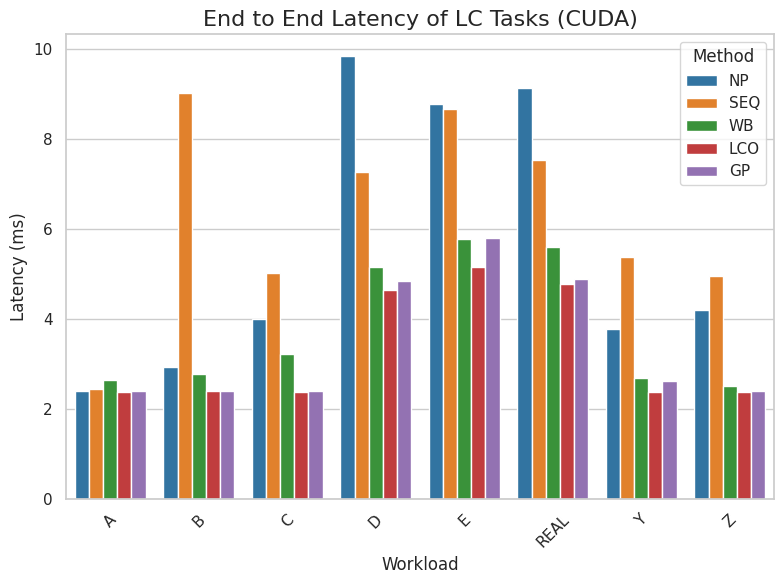

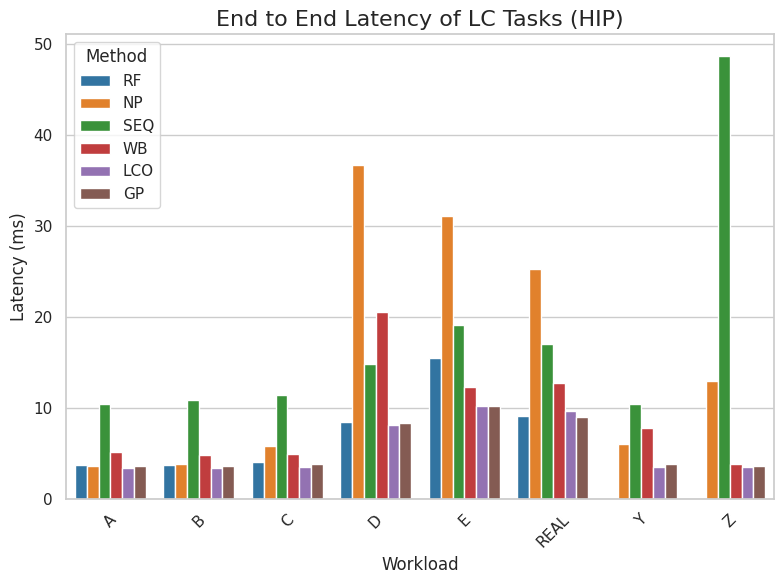

In [8]:
def generate_fig4_data(data_folder, platform, clients_to_process):
    data = defaultdict(dict)
    pattern = re.compile(rf'{platform}-(.+)-(.+)\.json')

    for root, _, files in os.walk(data_folder):
        for file in files:
            match = pattern.match(file)
            if match:
                baseline, workload = match.group(1), match.group(2)
                if baseline not in clients_to_process or workload not in WORKLOAD_ORDER:
                    continue
                
                filepath = os.path.join(root, file)
                file_data = read_json_file(filepath)
                
                if file_data and "results" in file_data:
                    latencies = [
                        result["analyzers"][0]["avgTotalLatency(us)"]
                        for result in file_data["results"]
                        if result["clientName"].endswith("_rt") and result["analyzers"]
                    ]
                    if latencies:
                        data[baseline][workload] = sum(latencies) / len(latencies)
                    else:
                        data[baseline][workload] = 0
                else:
                    data[baseline][workload] = 0
    
    df = pd.DataFrame(data)
    if df.empty: return pd.DataFrame()

    df = df.reindex(index=WORKLOAD_ORDER, columns=clients_to_process).fillna(0)
    df = df.div(1000) # us to ms
    df = df.rename(columns=CLIENT_TO_NAME)
    return df

# CUDA
df_cuda = generate_fig4_data(data_folder, "cuda", BASE_CLIENTS)
if not df_cuda.empty:
    df_cuda = df_cuda.reindex(columns=CLIENT_ORDER_NP_GP)
    plot_workload_methods(df_cuda, "End to End Latency of LC Tasks (CUDA)", "Workload", 
                            "Latency (ms)")

# HIP
hip_clients = ["reef_client"] + BASE_CLIENTS
df_hip = generate_fig4_data(data_folder, "hip", hip_clients)
if not df_hip.empty:
    df_hip = df_hip.reindex(columns=CLIENT_ORDER_RF_GP)
    plot_workload_methods(df_hip, "End to End Latency of LC Tasks (HIP)", "Workload", 
                            "Latency (ms)")

### Figure 5: LC and BE Task Throughput on Various Workloads.

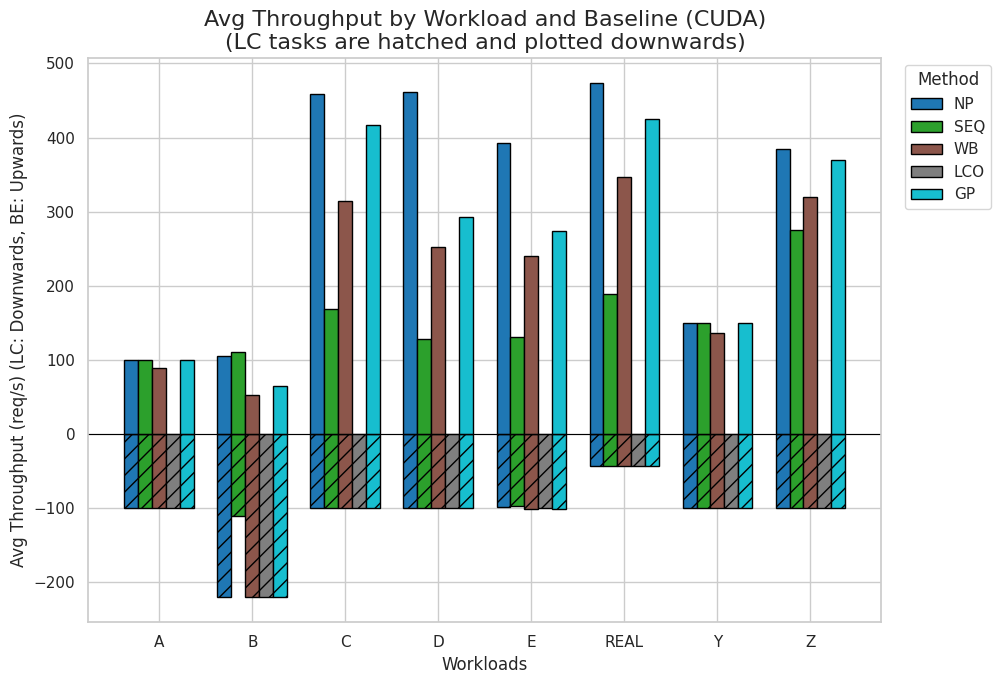

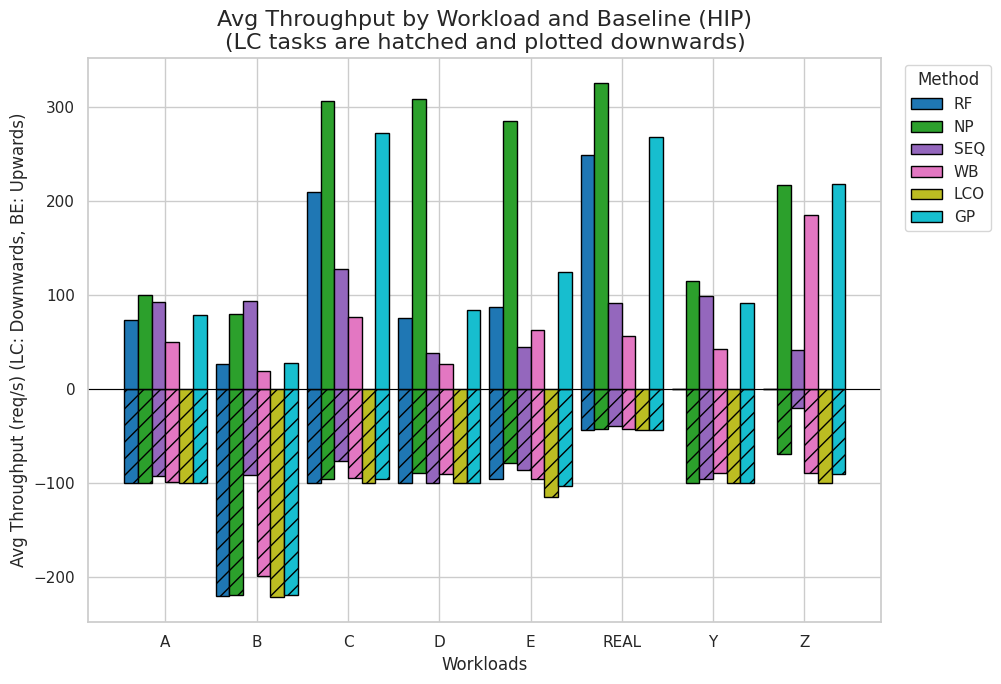

In [9]:
def generate_fig5_data(data_folder, platform, clients_to_process):
    rt_data = defaultdict(lambda: defaultdict(float))
    be_data = defaultdict(lambda: defaultdict(float))
    pattern = re.compile(rf'{platform}-(.+)-(.+?)\.json')

    for file_name in os.listdir(data_folder):
        match = pattern.match(file_name)
        if match:
            baseline, workload = match.group(1), match.group(2)
            if baseline not in clients_to_process or workload not in WORKLOAD_ORDER:
                continue

            filepath = os.path.join(data_folder, file_name)
            file_content = read_json_file(filepath)

            if file_content and "results" in file_content:
                for result in file_content["results"]:
                    if not result["analyzers"]: continue
                    avg_throughput = sum(analyzer["avgThroughput(req/s)"] for analyzer in result["analyzers"])
                    if '_rt' in result["clientName"]:
                        rt_data[workload][baseline] += avg_throughput
                    elif '_be' in result["clientName"]:
                        be_data[workload][baseline] += avg_throughput
            else:
                if workload not in rt_data or baseline not in rt_data[workload]:
                     rt_data[workload][baseline] = 0.0
                if workload not in be_data or baseline not in be_data[workload]:
                     be_data[workload][baseline] = 0.0

    df_rt = pd.DataFrame(rt_data).fillna(0).T.reindex(index=WORKLOAD_ORDER, columns=clients_to_process).rename(columns=CLIENT_TO_NAME)
    df_be = pd.DataFrame(be_data).fillna(0).T.reindex(index=WORKLOAD_ORDER, columns=clients_to_process).rename(columns=CLIENT_TO_NAME)
    
    return df_rt, df_be

def plot_fig5(data_folder, platform, client_order_to_use):
    clients_to_process = [k for k, v in CLIENT_TO_NAME.items() if v in client_order_to_use]
    df_rt, df_be = generate_fig5_data(data_folder, platform, clients_to_process)

    if df_rt.empty and df_be.empty:
        print(f"Skipping Fig 5 for {platform} due to no data.")
        return

    df_rt = df_rt.reindex(columns=client_order_to_use, fill_value=0)
    df_be = df_be.reindex(columns=client_order_to_use, fill_value=0)
    
    workloads = df_rt.index.tolist()
    baselines = df_rt.columns.tolist()
    n_workloads = len(workloads)
    n_baselines = len(baselines)

    bar_width = 0.15
    x = np.arange(n_workloads)
    
    plt.figure(figsize=(12, 7))
    plt.axhline(0, color='black', linewidth=0.8)

    colors = plt.cm.tab10(np.linspace(0, 1, n_baselines))

    for i, baseline in enumerate(baselines):
        rt_values = -df_rt[baseline].values 
        be_values = df_be[baseline].values
        
        plt.bar(x + i * bar_width, rt_values, width=bar_width, label=f"{baseline} (LC)", color=colors[i], edgecolor='black', hatch='//')
        plt.bar(x + i * bar_width, be_values, width=bar_width, label=f"{baseline} (BE)", color=colors[i], edgecolor='black')
        if i == 0:
             pass

    plt.xticks(x + (n_baselines - 1) * bar_width / 2, workloads)
    plt.xlabel("Workloads", fontsize=12)
    plt.ylabel("Avg Throughput (req/s) (LC: Downwards, BE: Upwards)", fontsize=12)
    plt.title(f"Avg Throughput by Workload and Baseline ({platform.upper()})\n(LC tasks are hatched and plotted downwards)", fontsize=16)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = []
    unique_handles = []
    seen_baselines = set()
    for label, handle in zip(labels, handles):
        baseline_name = label.split(" ")[0]
        if baseline_name not in seen_baselines:
             if "(BE)" in label:
                unique_labels.append(baseline_name)
                unique_handles.append(handle)
                seen_baselines.add(baseline_name)


    plt.legend(unique_handles, unique_labels, title="Method", loc="upper left", bbox_to_anchor=(1.02, 1))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    plt.show()

plot_fig5(data_folder, "cuda", CLIENT_ORDER_NP_GP)
plot_fig5(data_folder, "hip", CLIENT_ORDER_RF_GP)

### Figure 6: Additional Latency Comparing to LC Task Only.

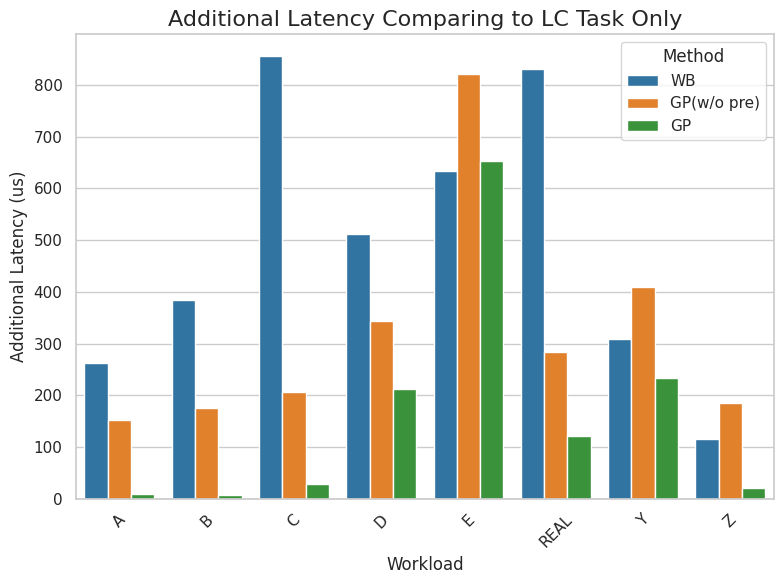

In [10]:
def generate_fig6_data(data_folder):
    # Step 1: Read rtonlyclient latencies (baseline)
    rtonly_latency = defaultdict(float)
    pattern_rtonly = re.compile(r'cuda-rtonlyclient-(.+)\.json')
    
    for file_name in os.listdir(data_folder):
        match = pattern_rtonly.match(file_name)
        if match:
            workload = match.group(1)
            if workload not in WORKLOAD_ORDER: continue

            filepath = os.path.join(data_folder, file_name)
            file_content = read_json_file(filepath)
            if file_content and "results" in file_content:
                for result in file_content["results"]:
                    if result["clientName"].endswith("_rt") and result["analyzers"]:
                        rtonly_latency[workload] += result["analyzers"][0]["avgTotalLatency(us)"]

    # Step 2: Compute additional latency for target clients
    additional_latency_data = defaultdict(lambda: defaultdict(float))
    targets_fig6 = ["blpclient", "gpreemptclient_wo", "gpreemptclient"]
    pattern_targets = re.compile(r'cuda-(.+)-(.+)\.json')

    for file_name in os.listdir(data_folder):
        match = pattern_targets.match(file_name)
        if match:
            baseline, workload = match.group(1), match.group(2)
            if baseline not in targets_fig6 or workload not in WORKLOAD_ORDER:
                continue

            filepath = os.path.join(data_folder, file_name)
            file_content = read_json_file(filepath)
            if file_content and "results" in file_content:
                current_total = 0
                rt_client_count = 0
                for result in file_content["results"]:
                    if result["clientName"].endswith("_rt") and result["analyzers"]:
                        current_total += result["analyzers"][0]["avgTotalLatency(us)"]
                        rt_client_count +=1
                if rt_client_count > 0:
                    additional_latency_data[baseline][workload] = (current_total - rtonly_latency[workload]) / rt_client_count


    df = pd.DataFrame(additional_latency_data).fillna(0)
    if df.empty: return pd.DataFrame()

    df = df.reindex(index=WORKLOAD_ORDER, columns=targets_fig6)
    df = df.rename(columns=CLIENT_TO_NAME)
    df = df.reindex(columns=['WB', "GP(w/o pre)", "GP"], fill_value=0)
    return df

df = generate_fig6_data(data_folder)
if not df.empty:
    plot_workload_methods(df, "Additional Latency Comparing to LC Task Only", "Workload", 
                            "Additional Latency (us)")
else:
    print("No valid data found for Figure 6.")

### Figure 7: Analysis of Hint-based Pre-preemption
(a) Additional latency on various data prepare time

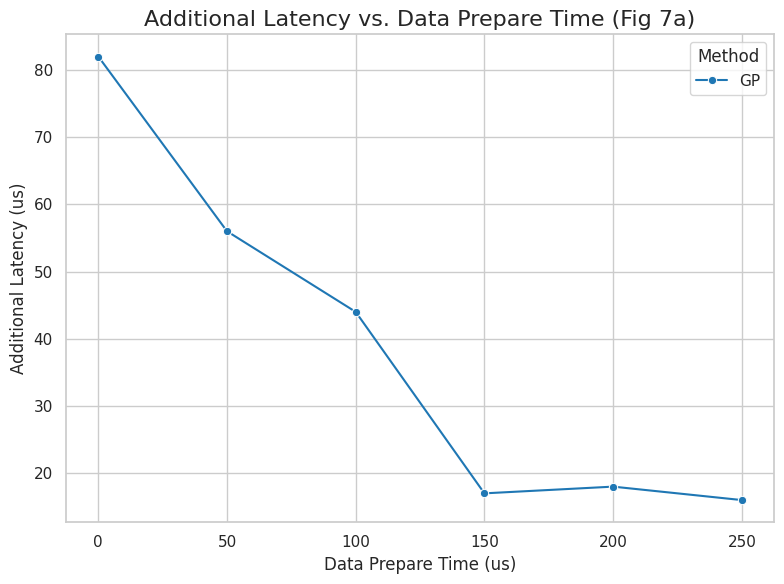

In [11]:
def generate_fig7a_data(data_folder):
    data = defaultdict(lambda: defaultdict(float))
    workloads_fig7a_map = {'A1': 0, 'A2': 50, 'A3': 100, 'A4': 150, 'A5': 200, 'A6': 250}
    
    pattern = re.compile(r'cuda-(gpreemptclient)-(.+)\.json')

    for file_name in os.listdir(data_folder):
        match = pattern.match(file_name)
        if match:
            baseline, workload_code = match.group(1), match.group(2)
            if workload_code not in workloads_fig7a_map:
                continue

            filepath = os.path.join(data_folder, file_name)
            file_content = read_json_file(filepath)

            if file_content and "results" in file_content:
                total_latency_increase = 0
                rt_client_count = 0
                for result in file_content["results"]:
                    if result["clientName"].endswith("_rt") and result["analyzers"]:
                        total_latency_increase += result["analyzers"][0]["avgTotalLatencyIncrease(us)"]
                        rt_client_count += 1
                
                if rt_client_count > 0:
                    avg_latency_increase = total_latency_increase / rt_client_count
                    data[baseline][workloads_fig7a_map[workload_code]] = avg_latency_increase
    
    df = pd.DataFrame(data).fillna(0)
    if df.empty: return pd.DataFrame()

    df = df.reindex(index=sorted(workloads_fig7a_map.values()))
    df = df.rename(columns=CLIENT_TO_NAME)
    return df


# Figure 7a
df_7a = generate_fig7a_data(data_folder)
if not df_7a.empty:
    plot_workload_methods(df_7a, "Additional Latency vs. Data Prepare Time (Fig 7a)", 
                            "Data Prepare Time (us)", "Additional Latency (us)", line_plot=True)


(b) BE tasks throughput on different LC task frequency.

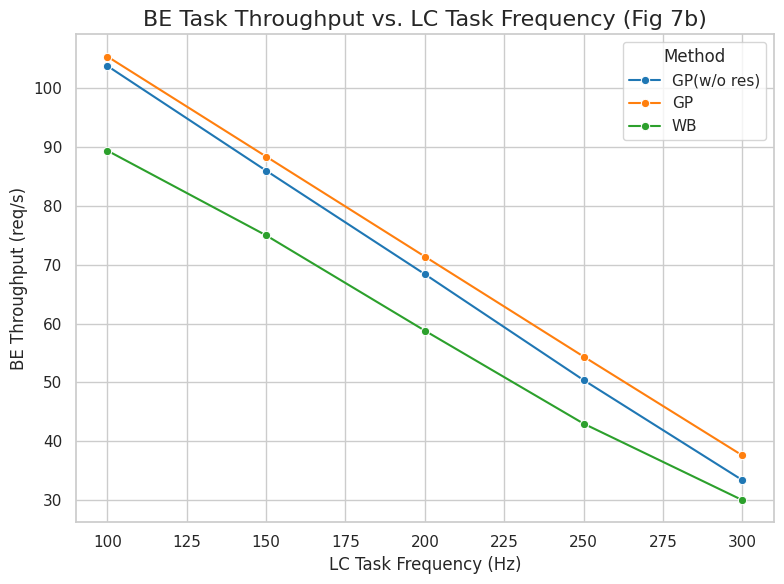

In [12]:
def generate_fig7b_data(data_folder):
    data = defaultdict(dict)
    targets_fig7b = ["gpreemptclient", "gpreemptclient_wo_res", "blpclient"]
    workloads_fig7b_map = {'B0': 100, 'B1': 150, 'B2': 200, 'B3': 250, 'B4': 300}
    for target in targets_fig7b:
        for workload_code, freq_val in workloads_fig7b_map.items():
            filepath = os.path.join(data_folder, f"cuda-{target}-{workload_code}.json")
            file_content = read_json_file(filepath)
            if file_content and "results" in file_content:
                for result in file_content["results"]:
                    if result["clientName"].endswith("_be") and result["analyzers"]:
                        data[target][freq_val] = sum(an["avgThroughput(req/s)"] for an in result["analyzers"])
                        break 
            else:
                 data[target][freq_val] = np.nan 
    df = pd.DataFrame(data).fillna(0)
    if df.empty: return pd.DataFrame()

    df = df.reindex(index=sorted(workloads_fig7b_map.values()))
    df = df.rename(columns=CLIENT_TO_NAME)
    df = df.reindex(columns=["GP(w/o res)", "GP", "WB"], fill_value=0)
    return df
 
# Figure 7b
df_7b = generate_fig7b_data(data_folder)
if not df_7b.empty:
    plot_workload_methods(df_7b, "BE Task Throughput vs. LC Task Frequency (Fig 7b)", 
                            "LC Task Frequency (Hz)", "BE Throughput (req/s)", line_plot=True)